In [14]:
import json
import os
import re
from typing import List, Optional, Tuple
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np



In [2]:

##### Preliminary functions

def Phi_Hl(l: int, H: float) -> float:
    """
    Compute the value of $\\Phi^H_\\ell$ using a finite difference formula.

    This function evaluates a discrete approximation based on powers of absolute values,
    commonly used in fractional Brownian motion and related models.

    :param l: Index $\\ell$ in the formula (integer).
    :param H: Hurst exponent $H$, controlling the memory effect (float).
    :return: Computed value of $\\Phi^H_\\ell$.
    """
    numerator = (np.abs(l + 2) ** (2 * H + 2) - 4 * np.abs(l + 1) ** (2 * H + 2) +
                 6 * np.abs(l) ** (2 * H + 2) - 4 * np.abs(l - 1) ** (2 * H + 2) +
                 np.abs(l - 2) ** (2 * H + 2))
    denominator = 2 * (2 * H + 1) * (2 * H + 2)
    return numerator / denominator

def dPhi_Hl_dH(l: int, H: float) -> float:
    """
    Compute the derivative of $\\Phi^H_\\ell$ with respect to $H$.

    Uses the chain rule to differentiate power terms in the finite difference formula.

    :param l: Index $\\ell$ in the formula (integer).
    :param H: Hurst exponent $H$ (float).
    :return: The computed derivative $\\frac{d}{dH} \\Phi^H_\\ell$.
    """
    def power_term_derivative(x, H):
        if x == 0:
            return 0
        return (2 * x ** (2 * H + 2) * np.log(np.abs(x)))
    
    numerator = (np.abs(l + 2) ** (2 * H + 2) - 4 * np.abs(l + 1) ** (2 * H + 2) +
                 6 * np.abs(l) ** (2 * H + 2) - 4 * np.abs(l - 1) ** (2 * H + 2) +
                 np.abs(l - 2) ** (2 * H + 2))

    numerator_derivative = (
        power_term_derivative(np.abs(l + 2), H) - 4 * power_term_derivative(np.abs(l + 1), H) +
        6 * power_term_derivative(np.abs(l), H) - 4 * power_term_derivative(np.abs(l - 1), H) +
        power_term_derivative(np.abs(l - 2), H)
    )
    
    denominator = 2 * (2 * H + 1) * (2 * H + 2)
    denominator_derivative = 4 * (4 * H + 3)
    
    return (numerator_derivative * denominator - denominator_derivative * numerator) / (denominator * denominator)

##### GMM estimator

def F_estimation_GMM(W: np.ndarray, V: np.ndarray, Psi_func, H: list, normalisation: float = 1) -> float:
    """
    Compute the GMM objective function $F(H, R)$ for given parameters.
    
    This function minimizes:
    
    $$ F(H, R) = (V - P)^T W (V - P) $$
    
    where $P$ is computed based on $H$.

    :param W: Weight matrix (numpy array).
    :param V: Observation vector (numpy array).
    :param Psi_func: Function $\\Psi(H)$ providing model predictions.
    :param H: Scalar Hurst exponent wrapped in a list.
    :param normalisation: Normalization factor for the function value.
    :return: Evaluated objective function value.
    """

    H = H[0]
    V = np.atleast_2d(V).reshape(-1, 1)
    Psi = np.atleast_2d(Psi_func(H)).reshape(-1, 1)
        
    term0 = V.T @ W @ V
    term1 = (Psi.T @ W @ V) + (V.T @ W @ Psi)
    term2 = Psi.T @ W @ Psi
    
    term0 = term0[0, 0]
    term1 = term1[0, 0]
    term2 = term2[0, 0]
    
    R = term1 / term2 / 2
    
    return normalisation * (term0 - R * term1 + term2 * R * R)

def F_GMM_get_R(W: np.ndarray, V: np.ndarray, Psi_func, H: float) -> float:
    V = np.atleast_2d(V).reshape(-1, 1)
    Psi = np.atleast_2d(Psi_func(H)).reshape(-1, 1)
        
    term0 = V.T @ W @ V
    term1 = (Psi.T @ W @ V) + (V.T @ W @ Psi)
    term2 = Psi.T @ W @ Psi
    
    term0 = term0[0, 0]
    term1 = term1[0, 0]
    term2 = term2[0, 0]
    
    R = term1 / term2 / 2
    
    return R

def estimation_GMM(W: np.ndarray, V: np.ndarray, Psi_func, H_min: float = 0.001, H_max: float = 0.499, mesh: float = 0.001, debug: bool = False):
    """
    Perform Generalized Method of Moments (GMM) estimation for the Hurst exponent.
    
    This method finds $H$ that minimizes the GMM objective function over a predefined grid.
    
    :param W: Weight matrix (numpy array).
    :param V: Observation vector (numpy array).
    :param Psi_func: Function returning model predictions $\\Psi(H)$.
    :param H_min: Minimum value for H search grid.
    :param H_max: Maximum value for H search grid.
    :param mesh: Step size for grid search.
    :param debug: If True, return intermediate results.
    :return: Estimated Hurst exponent.
    """
    H_values = np.arange(H_min, H_max, mesh)
    F_values = [F_estimation_GMM(W, V, Psi_func, [H]) for H in H_values]
    min_index = np.argmin(F_values)
    
    if debug:
        R_values = [F_GMM_get_R(W, V, Psi_func, H) for H in H_values]
        return H_values, F_values, min_index, R_values

    return H_values[min_index], F_GMM_get_R(W, V, Psi_func, H_values[min_index])


In [30]:
input_data = "prepared_data_volume.npy"

price_truncation_mode = 'BIVAR_3'  # None, STD_X, BIVAR_X (X int/float)
volatility_truncation_mode = 'STD_3'  # None, STD_X (X int/float)
remove_pattern = 'multiplicative'  # None, multiplicative, additive

window = 300  # Integer

hurst_min_value = 0.0001  # Float
hurst_max_value = 0.4999  # Float
hurst_step = 0.0001  # Float

normalise_average_value = True  # True or False, default True

N_autocorrelation = 3  # Integer (must be larger than 2)
compute_confidence_interval = True  # True or False, default is False
GMM_weight = "identity"  # "identity" or "optimal"
Ln = 180  # Integer, default value 180
Kn = 720  # Integer, default value 720
W_fun_id = "parzen"  # Only allowed value is 'parzen'



In [31]:
# Helper functions

def bipower_average_V(price, window):
    n = len(price)
    if n <= 2 * window:  # Ensure there's enough data
        print("Not enough data points.")
        return -1.0

    # Compute price increments over the given window
    price_increments = price[window:] - price[:-window]

    # Calculate bipower average volatility
    sum_ = np.sum(np.abs(price_increments[window:] * price_increments[:-window]))

    # Calculate the final result
    mean = sum_ / (n - 2 * window)
    return (mean / window) * (np.pi / 2)

def truncate_absolute(values, threshold):
    values = np.asarray(values).copy()
    values[np.abs(values) > threshold] = 0
    return values

def compute_volatility_squared(price, window_size, truncation_method=None, truncation_param=None):
    price = np.asarray(price, dtype=float)
    if np.any(price <= 0):
        raise ValueError("Price contains non-positive values; cannot take log.")

    log_price = np.log(price)
    log_returns = log_price[1:] - log_price[:-1]

    n, N = len(log_returns), 0

    if truncation_method is not None:
        if truncation_method == 'STD':
            std_dev = np.std(log_returns)
            threshold = float(truncation_param) * std_dev
            N = np.sum(np.abs(log_returns) > threshold)
            log_returns = truncate_absolute(log_returns, threshold)
        elif truncation_method == 'BIVAR':
            bpa = bipower_average_V(log_price, window_size)
            if bpa <= 0:
                # fall back to no truncation if bpa invalid
                pass
            else:
                threshold = float(truncation_param) * np.sqrt(bpa)
                N = np.sum(np.abs(log_returns) > threshold)
                log_returns = truncate_absolute(log_returns, threshold)

    rv = np.concatenate([[0.0], np.cumsum(log_returns ** 2)])
    volatilities_squared = (rv[window_size:] - rv[:-window_size]) / float(window_size)
    return volatilities_squared, n, N

def compute_autocorrelation(
    vol_squared,
    N_lags,
    window,
    truncation_method=None,
    truncation_param=None,
    return_counts=False,
):
    vol_squared = np.asarray(vol_squared, dtype=float)
    n = len(vol_squared)
    if n <= N_lags*window:
        raise ValueError("Not enough data points to compute autocorrelation with the given number of lags.")

    vol_squared_increments = vol_squared[window:] - vol_squared[:-window]
    n_increments = len(vol_squared_increments)
    truncated = 0

    if truncation_method is not None:
        if truncation_method == 'STD':
            std_dev = np.std(vol_squared_increments)
            threshold = float(truncation_param) * std_dev
            truncated = int(np.sum(np.abs(vol_squared_increments) > threshold))
            vol_squared_increments = truncate_absolute(vol_squared_increments, threshold)
        else:
            raise ValueError(f"Unknown truncation method: {truncation_method}")

    # mean_vol = np.mean(vol_squared_increments)
    mean_vol = 0
    autocorr = np.zeros(N_lags)

    for lag in range(N_lags):
        if lag == 0:
            autocorr[lag] = np.mean((vol_squared_increments - mean_vol) ** 2)
        else:
            autocorr[lag] = np.mean((vol_squared_increments[lag*window:] - mean_vol) * (vol_squared_increments[:-lag*window] - mean_vol))

    autocorr[1] = autocorr[0] + 2 * autocorr[1]

    if return_counts:
        return autocorr[1:], n_increments, truncated
    return autocorr[1:]

def correct_DRV(DRV, Kn):
    DRV = np.asarray(DRV)
    if len(DRV) < Kn:
        raise ValueError("DRV length must be at least Kn.")
    # Simple moving average
    kernel = np.ones(Kn) / Kn
    psi = np.convolve(DRV, kernel, mode='valid')
    return psi

def compute_term(psi, psi_prime, kn, kn_prime, L):
    """
    Compute a single term in the asymptotic variance estimator for a given lag L.
    
    Parameters
    ----------
    psi : np.ndarray
        A time series of corrected values.
    psi_prime : np.ndarray
        Another time series of corrected values.
    kn : float
        A scaling parameter.
    kn_prime : float
        Another scaling parameter.
    L : int
        The lag at which to compute the term.
    
    Returns
    -------
    float
        The computed term.
    """
    psi = np.asarray(psi)
    psi_prime = np.asarray(psi_prime)
    
    # Align psi and psi_prime based on lag L
    if L > 0:
        # psi_prime is shifted forward by L relative to psi
        # so we must drop the last L elements of psi and the first L elements of psi_prime
        psi_trunc = psi[:-L]
        psi_prime_trunc = psi_prime[L:]
    elif L < 0:
        # psi is shifted forward by -L relative to psi_prime
        # so we must drop the first -L elements of psi and the last -L elements of psi_prime
        shift = -L
        psi_trunc = psi[shift:]
        psi_prime_trunc = psi_prime[:-shift]
    else:
        # L = 0, no shift
        psi_trunc = psi
        psi_prime_trunc = psi_prime
    
    # Ensure equal lengths
    N = min(len(psi_trunc), len(psi_prime_trunc))
    if N == 0:
        return 0.0
    
    psi_trunc = psi_trunc[:N]
    psi_prime_trunc = psi_prime_trunc[:N]
    
    # Compute mean of product
    val = np.sum(psi_trunc * psi_prime_trunc)
    return val / (kn * kn_prime)

def compute_covariance(W_fun, 
                       Ln,
                       Kn, 
                       vol_squared, 
                       N_lags, 
                       window, 
                       truncation_method=None, 
                       truncation_param=None):
    if N_lags < 2:
        raise ValueError("N_lags must be >= 2 so autocovariance has size N_lags-1.")

    vol_squared = np.asarray(vol_squared, dtype=float)
    n = len(vol_squared)
    if n <= N_lags*window:
        raise ValueError("Not enough data points to compute autocorrelation with the given number of lags.")

    vol_squared_increments = vol_squared[window:] - vol_squared[:-window]

    if truncation_method is not None:
        if truncation_method == 'STD':
            std_dev = np.std(vol_squared_increments)
            threshold = float(truncation_param) * std_dev
            vol_squared_increments = truncate_absolute(vol_squared_increments, threshold)
        else:
            raise ValueError(f"Unknown truncation method: {truncation_method}")
    
    DRV = []
    for lag in range(N_lags):
        if lag == 0:
            DRV.append(vol_squared_increments**2)
        else:
            DRV.append(vol_squared_increments[(lag * window):] * vol_squared_increments[: - (lag * window)])
    DRV[0] = DRV[0][:len(DRV[1])]
    DRV[1] = DRV[0] + 2 * DRV[1]
    DRV = DRV[1:]

    psi = [correct_DRV(drv, Kn) for drv in DRV]

    sigma = np.zeros((N_lags-1, N_lags-1))

    for idx_i in range(N_lags-1):
        for idx_j in range(N_lags-1):
            for L in range(1, Ln + 1):
                w = W_fun(Ln,L)
                term = compute_term(psi[idx_i], psi[idx_j], window, window, L)
                sigma[idx_i, idx_j] += w * term


    sigma = sigma + sigma.transpose()

    # for idx_i in range(N_lags-1):
    #     for idx_j in range(N_lags-1):
    #         w = W_fun(Ln,0)
    #         sigma[idx_i, idx_j] += compute_term(psi[idx_i], psi[idx_j], window, window, 0)

    return sigma

### Confidence interval ###

def uncorrected_alpha(theta, lag, H):
    return theta**(2*H-1) * dPhi_Hl_dH(lag, H) + 2 * np.log(theta) * Phi_Hl(lag, H)

def uncorrected_beta(theta, lag, H):
    return theta**(2*H-1) * Phi_Hl(lag, H)

def compute_alpha(theta, lag, H):
    if lag == 1:
        return uncorrected_alpha(theta, 0, H) + 2 * uncorrected_alpha(theta, 1, H)
    return uncorrected_alpha(theta, lag, H)


def compute_beta(theta, lag, H):
    if lag == 1:
        return uncorrected_beta(theta, 0, H) + 2 * uncorrected_beta(theta, 1, H)
    return uncorrected_beta(theta, lag, H)




def get_confidence_size(N_lags, window, H_estimated, R_estimated, n_days, delta_n, Sigma_estimated, W_chosen):
    theta = 1

    alpha = np.zeros(N_lags-1)
    beta = np.zeros(N_lags-1)

    for i in range(1,N_lags):
        alpha[i-1] = compute_alpha(theta, i, H_estimated)
        beta[i-1] = compute_beta(theta, i, H_estimated)

    alpha_beta = np.array([alpha, beta])

    u_t = np.array([alpha * R_estimated, beta]).transpose()

    D = np.array([
        [1, 0],
        [-2 * np.log(window * delta_n), 1]
    ])

    uWu_inv = np.linalg.inv(u_t.transpose() @ W_chosen @ u_t)
    matrix_43 = (delta_n * window)**(1-4*H_estimated) * window * delta_n * D @ uWu_inv @ u_t.transpose() @ W_chosen @ Sigma_estimated @ W_chosen @ u_t @ uWu_inv @ D.transpose()

    return matrix_43[0,0]**0.5 / np.sqrt(n_days), matrix_43[1,1]**0.5  / np.sqrt(n_days)



def parse_truncation_mode(mode: Optional[str]) -> Tuple[Optional[str], Optional[float]]:
    """
    Parse truncation modes like:
      - None
      - "STD_3" or "STD_3.5"
      - "BIVAR_4" or "BIVAR_2.0"
    Returns (method, param) where method in {"STD","BIVAR"} or None.
    """
    if mode is None:
        return None, None
    if not isinstance(mode, str):
        raise ValueError(f"Invalid truncation mode type: {type(mode)}")
    m = re.match(r"^(STD|BIVAR)_(\d+(\.\d+)?)$", mode.strip().upper())
    if not m:
        raise ValueError(f"Invalid truncation mode format: {mode}. Expected None, STD_X or BIVAR_X.")
    method = m.group(1)
    param = float(m.group(2))
    return method, param


def create_Psi_function(window: int, N_lags: int):
    def Psi(H):
        """
        Precompute the Psi(H) function for the given parameter configurations.
        Psi(H) uses the pre-defined parameters (window sizes and number of lags)
        to generate a set of values that depend on H.

        Parameters
        ----------
        H : float
            The Hurst exponent value to use for computations.
        params : list of dict
            A list of parameter configurations. Each dict contains:
            - 'window': int
            - 'N_lags': int

        Returns
        -------
        np.array
            A NumPy array of computed Psi values.
        """
        p = []

        factor = window**(2 * H)
        
        # Compute the first two terms outside the loop
        p.append(factor * (Phi_Hl(0, H) + 2 * Phi_Hl(1, H)))

        # Compute remaining terms for i in [2, N_lags]
        for i in range(2, N_lags):
            p.append(factor * Phi_Hl(i, H))

        return np.array(p)
    return Psi



In [32]:
save_days = [100, 200, 300, 400]

In [33]:
# Step 0
print("Step 0/7: Checking input/output folders and creating output folder if needed...")

W_fun = None
if W_fun_id == "parzen":
    kernel_k = lambda x: 1 - 6 * x**2 + 6 * x**3 if x <= 0.5 else 2 * (1 - x)**3
    W_fun = lambda Lmax, L: kernel_k(np.abs(L / Lmax))
else:
    #TODO Improve exception
    raise -1

if input_data is None:
    raise ValueError("Config error: input_data is None.")

window = int(window)

# Parse truncation
volume_trunc_method, volume_trunc_param = parse_truncation_mode(volatility_truncation_mode)

# Step 1
print("Step 1/7: Listing files, filtering by prefix+date format, loading prices, applying filters...")

input_data = os.path.join(input_data)

X = np.load(input_data, allow_pickle=True)

n_day, volume_per_day = X.shape
daily_volume = [X[i, :] for i in range(n_day)]

# Step 2
print("Step 2/7: Computing daily volatility-squared series for each day...")

daily_volume_intensity_list: List[np.ndarray] = []

n_total = 0
N_total = 0

for volume in daily_volume:
    try:
        cumsum_volume = np.cumsum(volume)
        volume_intensity = cumsum_volume[window:] - cumsum_volume[:-window]
        daily_volume_intensity_list.append(volume_intensity.astype(float))
    except Exception:
        continue

if not daily_volume_intensity_list:
    print("No volume intensity series could be computed.")



Step 0/7: Checking input/output folders and creating output folder if needed...
Step 1/7: Listing files, filtering by prefix+date format, loading prices, applying filters...
Step 2/7: Computing daily volatility-squared series for each day...


In [34]:
save_raw_daily_volume_intensity = [
    daily_volume_intensity_list[i] for i in save_days
]



In [35]:
# Step 3
print("Step 3/7: Normalising and removing intraday volatility pattern if applicable...")

# Align lengths (pattern removal and averaging require same intraday index)
min_len = min(v.shape[0] for v in daily_volume_intensity_list)
max_len = max(v.shape[0] for v in daily_volume_intensity_list)
print(f"Volume intensity length range: min={min_len}, max={max_len}")
daily_volume_intensity_list = [v[:min_len].copy() for v in daily_volume_intensity_list]

# Normalise average value per day
if normalise_average_value:
    for i, v in enumerate(daily_volume_intensity_list):
        avg = float(np.mean(v))
        if avg != 0.0 and np.isfinite(avg):
            daily_volume_intensity_list[i] = v / avg

save_normalised_daily_volume_intensity = [
    daily_volume_intensity_list[i] for i in save_days
]

# Remove intraday pattern
if remove_pattern is not None:
    rp = str(remove_pattern).strip().lower()
    if rp == "multiplicative":
        stacked = np.vstack(daily_volume_intensity_list)  # shape (n_days, min_len)
        pattern = np.mean(stacked, axis=0)
        # avoid divide-by-zero
        pattern = np.where(pattern == 0.0, 1.0, pattern)
        for i, v in enumerate(daily_volume_intensity_list):
            daily_volume_intensity_list[i] = v / pattern
    elif rp == "additive":
        raise ValueError("remove_pattern='additive' is not supported.")
    else:
        raise ValueError(f"Invalid remove_pattern: {remove_pattern}. Expected None, 'multiplicative', or 'additive'.")

save_corrected_daily_volume_intensity = [
    daily_volume_intensity_list[i] for i in save_days
]


Step 3/7: Normalising and removing intraday volatility pattern if applicable...
Volume intensity length range: min=23100, max=23100


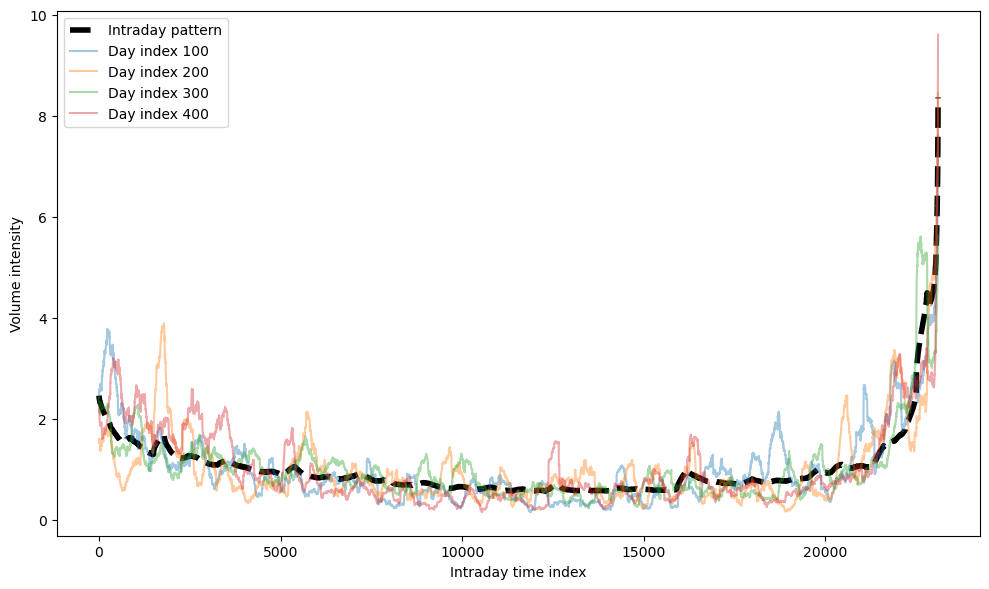

In [36]:
plt.figure(figsize=(10, 6))

# Plot intraday pattern (bold and prominent)
plt.plot(
    pattern,
    label="Intraday pattern",
    linewidth=4,          # bolder line
    linestyle="--",
    color="black"         # optional: force strong contrast
)

# Plot daily volume intensity curves (lighter)
for i in range(4):
    plt.plot(
        save_normalised_daily_volume_intensity[i],
        label=f"Day index {save_days[i]}",
        linewidth=1.5,
        alpha=0.4           # lighter / more transparent
    )

plt.xlabel("Intraday time index")
plt.ylabel("Volume intensity")
plt.legend()
plt.tight_layout()
plt.show()


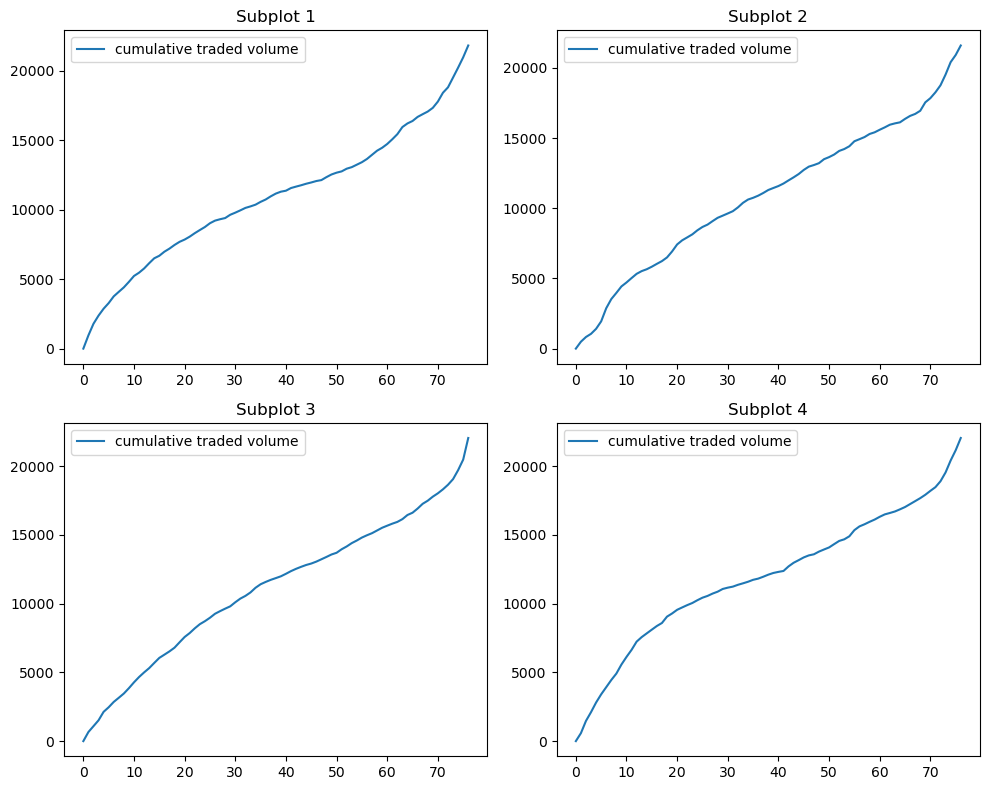

In [44]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i in range(4):
    path = save_normalised_daily_volume_intensity[i]
    path = np.cumsum(path).tolist()[::window]
    axes[i].plot(
        path,
        label="cumulative traded volume"
    )
    
    axes[i].set_title(f"Subplot {i + 1}")
    axes[i].legend()

plt.tight_layout()
plt.show()

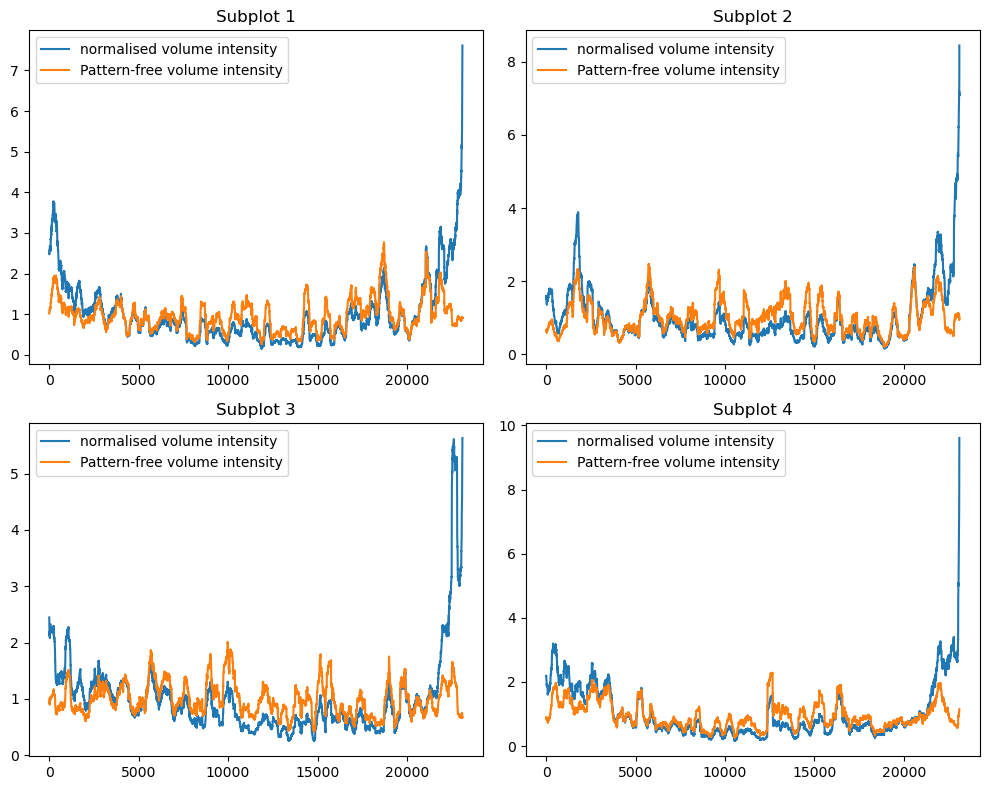

In [37]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i in range(4):
    axes[i].plot(
        save_normalised_daily_volume_intensity[i],
        label="normalised volume intensity"
    )
    axes[i].plot(
        save_corrected_daily_volume_intensity[i],
        label="Pattern-free volume intensity"
    )
    
    axes[i].set_title(f"Subplot {i + 1}")
    axes[i].legend()

plt.tight_layout()
plt.show()

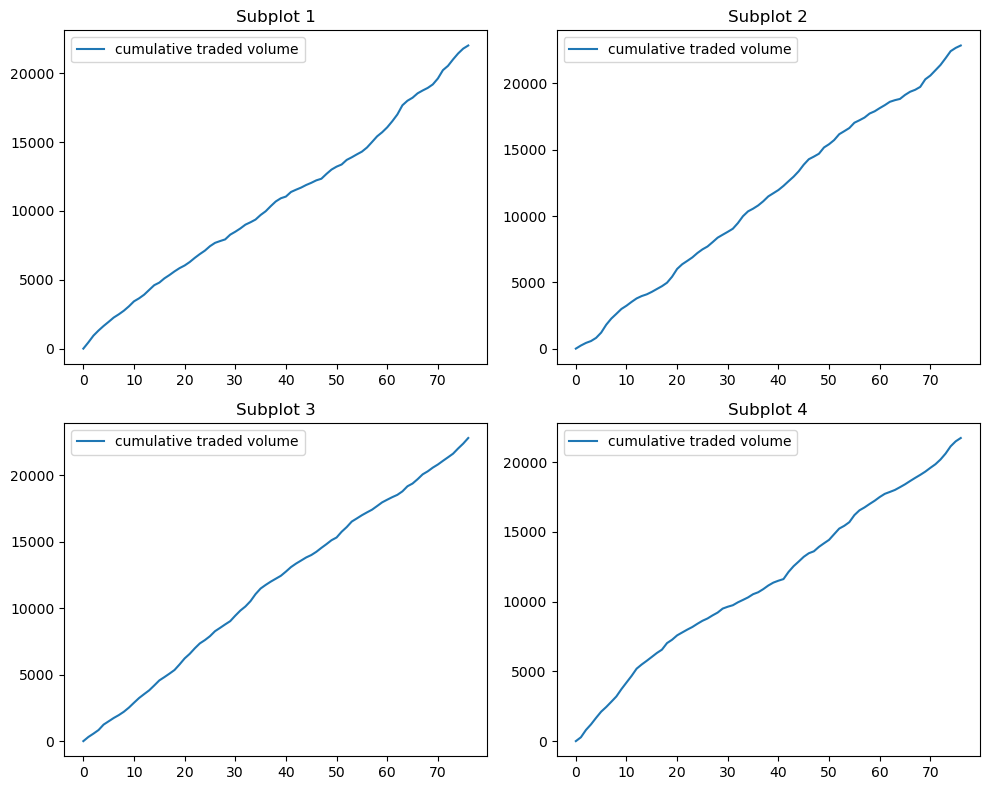

In [45]:
# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i in range(4):
    path = save_corrected_daily_volume_intensity[i]
    path = np.cumsum(path).tolist()[::window]
    axes[i].plot(
        path,
        label="cumulative traded volume"
    )
    
    axes[i].set_title(f"Subplot {i + 1}")
    axes[i].legend()

plt.tight_layout()
plt.show()

# Test truncation

In [38]:
def truncated_version(path, window):
    increments = path[window:] - path[:-window]
    std_value = np.std(increments)
    increments_sampled = increments[::window]
    return increments_sampled, std_value


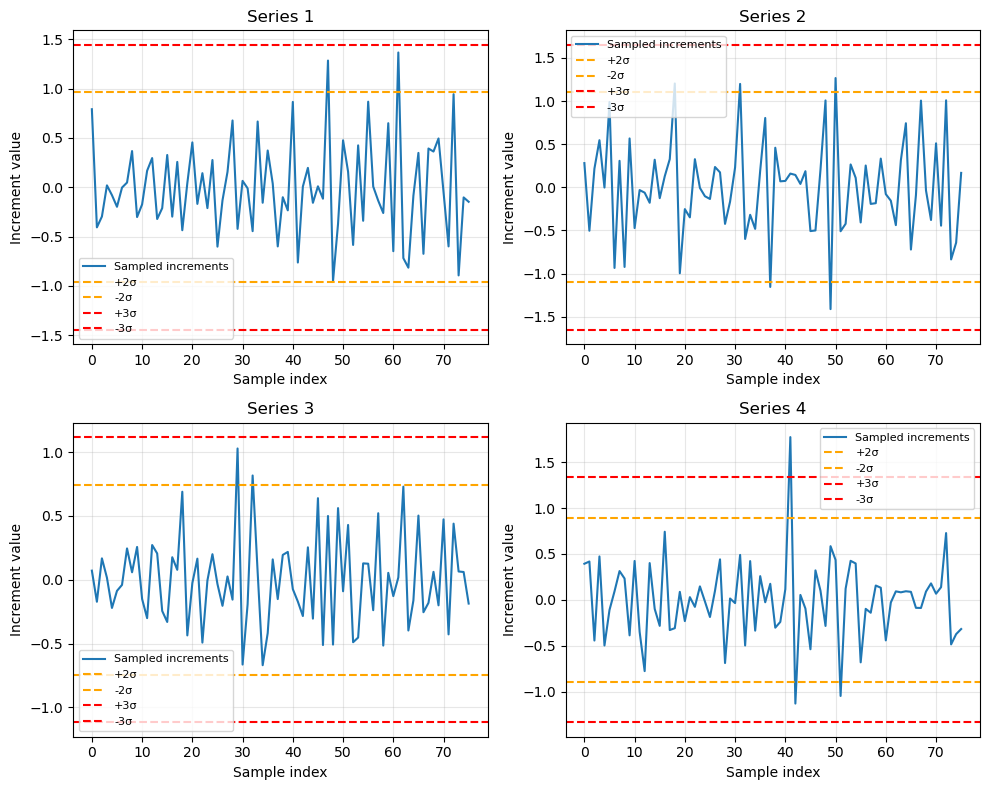

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i in range(4):
    ax = axes[i]
    path = save_corrected_daily_volume_intensity[i]

    # Compute increments
    increments = path[window:] - path[:-window]
    std_value = np.std(increments)

    # Sample increments every `window` steps
    increments_sampled = increments[::window]
    x = np.arange(len(increments_sampled))

    # Plot sampled increments
    ax.plot(x, increments_sampled, label="Sampled increments")

    # Plot threshold lines
    ax.axhline(2 * std_value, linestyle="--", color="orange", label="+2σ")
    ax.axhline(-2 * std_value, linestyle="--", color="orange", label="-2σ")
    ax.axhline(3 * std_value, linestyle="--", color="red", label="+3σ")
    ax.axhline(-3 * std_value, linestyle="--", color="red", label="-3σ")

    # Formatting
    ax.set_title(f"Series {i + 1}")
    ax.set_xlabel("Sample index")
    ax.set_ylabel("Increment value")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


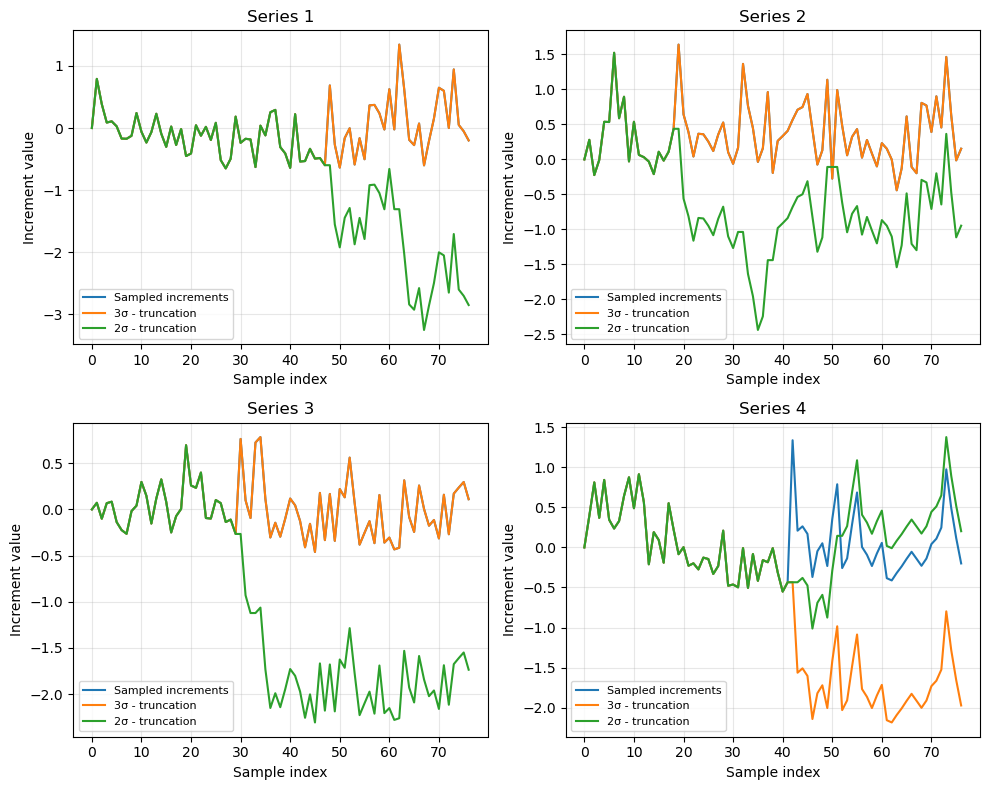

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Flatten axes array for easy indexing
axes = axes.flatten()

for i in range(4):
    ax = axes[i]
    path = save_corrected_daily_volume_intensity[i]

    # Compute increments
    increments = path[window:] - path[:-window]
    std_value = np.std(increments)

    # Sample increments every `window` steps
    increments_sampled = increments[::window]
    x = np.arange(len(increments_sampled) + 1)

    # Plot sampled increments
    ax.plot(x, [0] + np.cumsum(increments_sampled).tolist(), label="Sampled increments")

    increments_sampled[np.abs(increments_sampled) > 3 * std_value] = 0
    ax.plot(x, [0] + np.cumsum(increments_sampled).tolist(), label="3σ - truncation")

    increments_sampled[np.abs(increments_sampled) > 2 * std_value] = 0
    ax.plot(x, [0] + np.cumsum(increments_sampled).tolist(), label="2σ - truncation")

    # Formatting
    ax.set_title(f"Series {i + 1}")
    ax.set_xlabel("Sample index")
    ax.set_ylabel("Increment value")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [28]:
np.cumsum(increments_sampled).tolist()

[-0.35193357974905026,
 -0.33516435767727715,
 -0.3469946292827065,
 -0.4649278605777656,
 -0.4118126250397457,
 -0.603124396225757,
 -0.47607942150005333,
 -0.5243612253551744,
 -0.32875489580594597,
 -0.6794326376897892,
 -0.7766517503362301,
 -0.3849478378118314,
 -0.6076770050081809,
 -0.050732805422740945,
 0.36329080867750396,
 -0.540503795114864,
 0.003672619879047767,
 -0.11201586636309369]

In [ ]:
# Step 4: Estimate autocorrelation vectors
print("Step 4/7: Estimating autocorrelation vectors...")

if N_autocorrelation is None or int(N_autocorrelation) <= 2:
    raise ValueError("Config error: N_autocorrelation must be an integer greater than 2.")
n_lags = int(N_autocorrelation)

series_len = daily_volume_intensity_list[0].shape[0]
if series_len <= n_lags:
    raise ValueError(
        f"Config error: N_autocorrelation ({n_lags}) must be smaller than the volatility series length ({series_len})."
    )

daily_autocorr_vectors: List[np.ndarray] = []
n_increments_total = 0
truncated_increments_total = 0
for vsq in daily_volume_intensity_list:
    autocorr, n_increments, truncated = compute_autocorrelation(
        vsq,
        n_lags,
        window,
        truncation_method=volume_trunc_method,
        truncation_param=volume_trunc_param,
        return_counts=True,
    )
    daily_autocorr_vectors.append(autocorr)
    n_increments_total += n_increments
    truncated_increments_total += truncated

daily_autocorr_matrix = np.vstack(daily_autocorr_vectors)
average_autocorrelation = np.mean(daily_autocorr_matrix, axis=0)

# print(f"Average autocorrelation vector: {average_autocorrelation}")
proportion = (
    truncated_increments_total / n_increments_total
    if n_increments_total > 0
    else 0.0
)
print(
    "Volume intensity increments truncated: "
    f"{truncated_increments_total} out of {n_increments_total} "
    f"(proportion: {proportion:.6f})"
)

# Step 5: Estimate covariance matrices
print("Step 5/7: Estimating covariance matrices...")

daily_covariance_matrices: List[np.ndarray] = []

if GMM_weight not in {"identity", "optimal"}:
    raise ValueError(f"Invalid GMM_weight: {GMM_weight}. Expected 'identity' or 'optimal'.")
if GMM_weight == "optimal" or compute_confidence_interval:
    for vsq in daily_volume_intensity_list:
        daily_covariance_matrices.append(compute_covariance(
            W_fun, 
            Ln,
            Kn, 
            vsq, 
            n_lags, 
            window, 
            truncation_method=volume_trunc_method, 
            truncation_param=volume_trunc_param
        ).flatten())
    daily_covariance_matrices = np.vstack(daily_covariance_matrices)
    average_covariance = np.mean(daily_covariance_matrices, axis=0).reshape((n_lags - 1, n_lags - 1))
    
# Step 6: GMM estimation of Hurst exponent
print(
    f"Step 6/7: Estimating Hurst exponent via GMM on grid H in "
    f"[{hurst_min_value}, {hurst_max_value}] with step {hurst_step}..."
)

Psi = create_Psi_function(window, n_lags)

weight_matrix = np.identity(n_lags - 1)
if GMM_weight == "optimal":
    weight_matrix = np.linalg.inv(average_covariance)

H_total, R_total = estimation_GMM(weight_matrix,
                        average_autocorrelation,
                        Psi,
                        hurst_min_value,
                        hurst_max_value,
                        hurst_step)

print(average_autocorrelation)

# Step 7: Save results to output folder and print results as well
print("Step 7/7: Saving results and printing summary...")
print(f"Estimated Hurst exponent: {H_total}")

if compute_confidence_interval:
    n_days = len(daily_volume_intensity_list)

    C1, C2 = get_confidence_size(n_lags, window, H_total, R_total, n_days, delta_n, average_covariance, weight_matrix)
    alpha = 0.95  # Example: 95% confidence interval
    z_alpha = norm.ppf((1 + alpha) / 2)  # Compute Φ^−1((1 - α) / 2)
    print("Size confidence band:", C1 * z_alpha)

